In [1]:
import pathlib as pl
from PIL import Image
import datasets
from datasets import Dataset
from datasets import Image as DSImage
import numpy as np
import cv2
import matplotlib.pyplot as plt
# files = list((pl.Path(__file__).parent / "inference_inputs").glob("*"))
files = list((pl.Path(".").parent / "inference_inputs").glob("*"))
print(files)
# exit()


/home/users/aashrayc/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[PosixPath('inference_inputs/36_0009200_0009224-reel_begin_end.tiff')]


/home/users/aashrayc/.local/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (91173600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


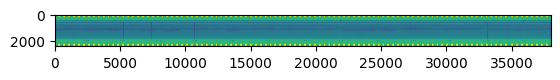

In [2]:
plt.imshow(Image.open(files[0]))

In [65]:

def window_with_remainder(length, overlap, input_size):
    testarray = np.arange(0, input_size)
    return np.vstack(
        (
            testarray[0:length],
            np.lib.stride_tricks.sliding_window_view(
                testarray[len(testarray) % length :], length
            )[::overlap],
        )
    )[:, [0, -1]] + [0, 1]
# Converts an image from cv2 to PIL
def convert_from_cv2_to_image(img: np.ndarray) -> Image:
    # return Image.fromarray(img)
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# Converts an image from PIL to cv2
def convert_from_image_to_cv2(img: Image) -> np.ndarray:
    # return np.asarray(img)
    return cv2.cvtColor(src=np.array(img, dtype=np.uint8), code=cv2.COLOR_RGB2BGR)
# Splits an longer image into a series of smaller images with a given overlap
# to reduce memory costs it takes in the length, input size and returns a list of valid indices
def window_with_remainder(length, overlap, input_size):
    testarray = np.arange(0, input_size)
    return np.vstack(
        (
            testarray[0:length],
            np.lib.stride_tricks.sliding_window_view(
                testarray[len(testarray) % length :], length
            )[::overlap],
        )
    )[:, [0, -1]] + [0, 1]
# does canny edge detection on an image
def canny_image(image: Image):
    # Read the image

    # Convert the image to grayscale
    gray = cv2.cvtColor(convert_from_image_to_cv2(image), cv2.COLOR_BGR2GRAY)

    combined_image = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    
    blurred = cv2.GaussianBlur(gray,(7,7),0)

    green = cv2.convertScaleAbs(cv2.Laplacian(blurred,cv2.CV_32F,7))
    blue = cv2.convertScaleAbs(cv2.Scharr(blurred,cv2.CV_32F,0,1))
    multg= 255/max(green.flatten())
    
    combined_image[:,:,0] = gray
    combined_image[:,:,1] = np.clip(np.round(green*int(multg)),0,255)
    combined_image[:,:,2] = np.clip(np.round(blue),0,255)
   
    
    return convert_from_cv2_to_image(combined_image)

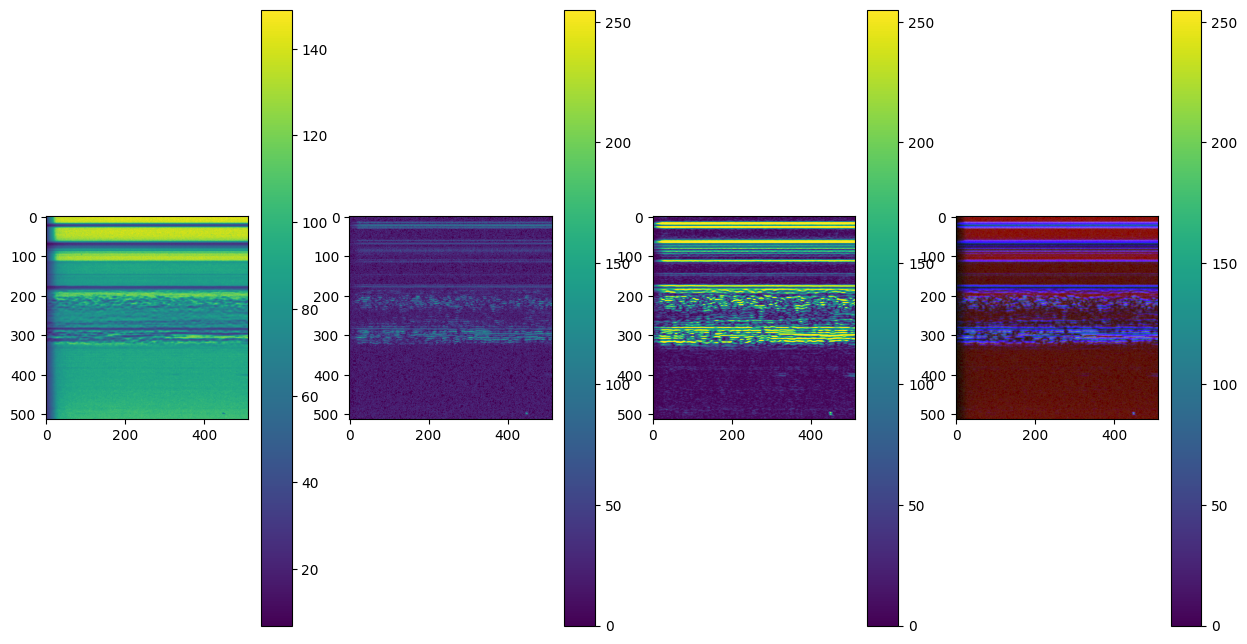

finished inference_raw_imgs/36_0009200_0009224-reel_begin_end/0-0-512.png

--



In [66]:
image_paths = []
for c, i in enumerate(files):
    img = Image.open(i)
    img = img.crop((0, 430, img.size[0], 1790))
    img = Image.fromarray(np.array(img) / 255)
    img = img.convert("L")
    cropping_coordinates = window_with_remainder(512, 128, img.size[0])
    file_path = pl.Path("./inference_raw_imgs") / i.stem
    file_path.mkdir(exist_ok=True)
    for count, (start, end) in enumerate(cropping_coordinates):
        save_path = file_path / f"{count}-{start}-{end}.png"
        cimg = img.crop((start, 0, end, img.size[1])).resize((512, 512))
        resized = canny_image(cimg)
        resized.save(save_path)    
        print(f"finished {save_path}")
        image_paths.append(str(save_path.resolve()))
        break
    print("\n--\n")


In [5]:
dataset = Dataset.from_dict({"image": sorted(image_paths)})
dataset = dataset.cast_column("image", DSImage())
# prints dataset information
print(dataset)
print(dataset.info)
print(dataset.features)

dataset.save_to_disk("./inference_dataset/inference_dataset.hf")



Dataset({
    features: ['image'],
    num_rows: 1
})
DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None)}, post_processed=None, supervised_keys=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)
{'image': Image(mode=None, decode=True, id=None)}


Saving the dataset (1/1 shards): 100%|██████████| 1/1 [00:00<00:00, 23.22 examples/s]
